#### Résumé : utilisation d'un modèle XGBoost : XGBRegressor
| Étape                                 | Détail                                                                    |
| ------------------------------------- | ------------------------------------------------------------------------- |
| **Connexion BigQuery**                | `from_service_account_json("cle_bigquery.json")`                          |
| **Requête SQL**                       | Agrégation du CA mensuel par catégorie en excluant les commandes annulées |
| **Conversion date**                   | Création d’une colonne `date` à partir de `annee` et `mois`               |
| **Tri temporel**                      | `sort_values(['categorie', 'date'])`                                      |
| **Création de variables de tendance** | Décalages (`shift`) et transformations (`rolling`, `pct_change`)          |
| **Nettoyage final**                   | Suppression des lignes incomplètes avec `dropna()`                        |


In [42]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client.from_service_account_json("cle_bigquery.json")

requete = """
SELECT
  d.annee,
  d.mois,
  p.categorie,
  SUM(f.montant_commande_apres_promotion) AS ca_ventes
FROM dataset_transformed_by_dbt.mrt_fct_commandes f
JOIN dataset_transformed_by_dbt.mrt_dim_produits p ON f.id_produit = p.id_produit
JOIN dataset_transformed_by_dbt.mrt_dim_dates d ON CAST(f.date_commande AS DATE) = d.date_jour
WHERE statut_commande != 'Annulée'
GROUP BY d.annee, d.mois, p.categorie
ORDER BY d.annee, d.mois, p.categorie
"""

df = client.query(requete).to_dataframe()
print (df) 

df['date'] = pd.to_datetime(df['annee'].astype(str) + '-' + df['mois'].astype(str) + '-01')
df = df.sort_values(['categorie', 'date'])
df['ca_mois_prec'] = df.groupby('categorie')['ca_ventes'].shift(1)
df['ca_mois_prec_2'] = df.groupby('categorie')['ca_ventes'].shift(2)
df['moyenne_mobile_3m'] = df.groupby('categorie')['ca_ventes'].transform(lambda x: x.rolling(3).mean())
df['variation_pourcent'] = df.groupby('categorie')['ca_ventes'].pct_change()
df_modele = df.dropna()


     annee  mois     categorie   ca_ventes
0     2023    12  Alimentation      626.94
1     2023    12        Beauté     8626.70
2     2023    12        Jouets    27677.49
3     2023    12        Livres   120337.63
4     2023    12        Maison   150761.27
..     ...   ...           ...         ...
99    2024    12        Livres   233196.04
100   2024    12        Maison   314450.68
101   2024    12          Mode  1598514.83
102   2024    12        Sports   431659.40
103   2024    12  Électronique  3210182.78

[104 rows x 4 columns]


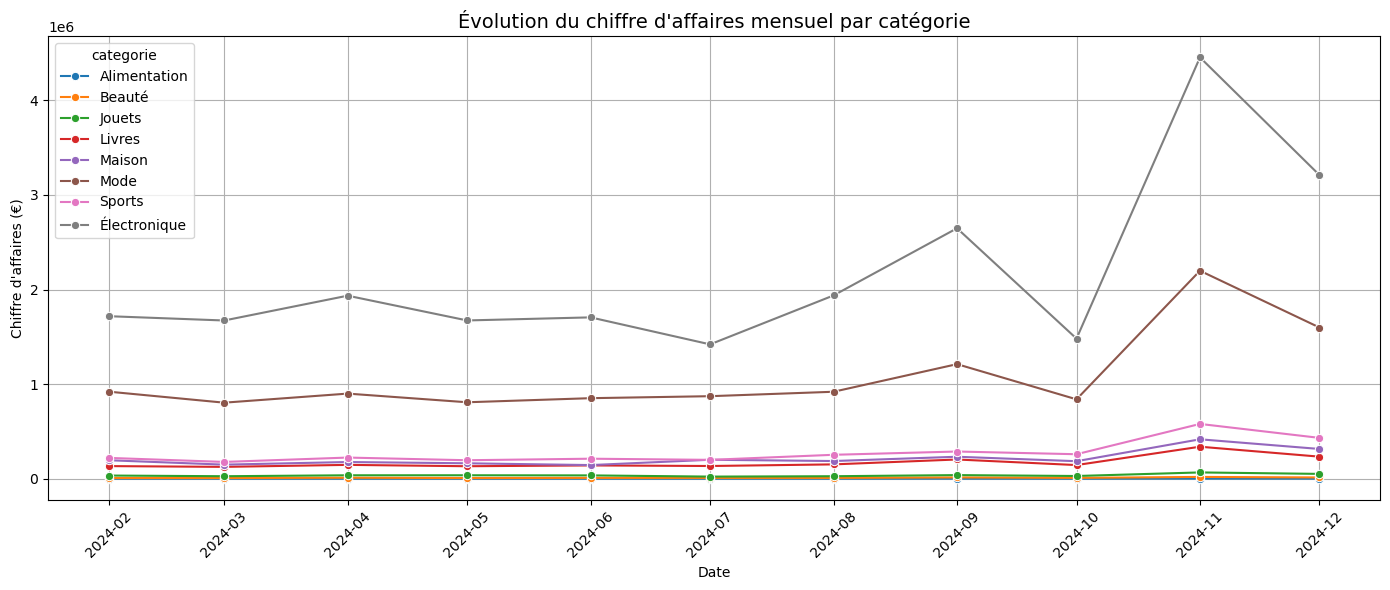

In [15]:
#  vérifier visuellement l’évolution des ventes avec un graphique par catégorie
import matplotlib.pyplot as plt
import seaborn as sns

# Taille de la figure
plt.figure(figsize=(14, 6))

# Courbes de CA par catégorie
sns.lineplot(data=df_modele, x='date', y='ca_ventes', hue='categorie', marker='o')

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaires mensuel par catégorie", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Affichage
plt.show()




#### ✅ Étapes couvertes :
- Encodage des catégories (one-hot encoding)
- Séparation entraînement / test
- Entraînement du modèle XGBoost
- Évaluation : MAE, RMSE, R²

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# 1. Encodage des catégories (one-hot) : transformer une variable catégorielle (categorie) en variables numériques binaire
df_encoded = pd.get_dummies(df_modele, columns=['categorie'], drop_first=False)

# 2. Définition des variables
X = df_encoded.drop(columns=['ca_ventes', 'date'])
y = df_encoded['ca_ventes']

# 3. Split train/test (sans shuffle car données temporelles)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Entraînement du modèle
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# 5. Évaluation sur les données de test
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🔸 MAE  : {mae:,.0f} €")
print(f"🔸 RMSE : {rmse:,.0f} €")
print(f"🔸 R²   : {r2:.2f}")


🔸 MAE  : 404,638 €
🔸 RMSE : 727,290 €
🔸 R²   : 0.59


#### 📊 Évaluation du modèle de régression XGBoost
| **Indicateur** | **Valeur** | **Interprétation**                                                                                                                           |
| -------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **MAE**        | 404 638 €  | En moyenne, les prédictions du modèle s'écartent de **\~405 000 €** du CA réel.                                                              |
| **RMSE**       | 727 290 €  | Les écarts les plus importants sont plus pénalisés ; cela indique des **pics d'erreur** ponctuels.                                           |
| **R²**         | 0.59       | Le modèle explique **59 % de la variance** du chiffre d’affaires mensuel par catégorie. C’est un score **correct**, mais encore améliorable. |


### Prédictions CA 2025 

In [24]:
#### Etape 1 : Générer les mois de l’année 2025 : On crée un DataFrame avec les mois de 2025 pour chaque catégorie présente dans les données historiques.
# Récupérer les dernières données disponibles
dernier_mois = df['date'].max()
dernieres_donnees = df[df['date'] == dernier_mois]

# Préparer les mois à prédire (janvier à décembre 2025)
mois_2025 = pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')
categories = df['categorie'].unique()

# Créer un DataFrame vide pour accueillir les prédictions
df_pred_2025 = pd.DataFrame([(cat, date) for cat in categories for date in mois_2025], columns=['categorie', 'date'])
df_pred_2025['annee'] = df_pred_2025['date'].dt.year
df_pred_2025['mois'] = df_pred_2025['date'].dt.month


#### Étape 2 : Ajouter les features (comme en entraînement)
Pour chaque mois et catégorie, il faut retrouver :
ca_mois_prec (CA du mois précédent),
ca_mois_prec_2 (CA deux mois avant),
moyenne_mobile_3m (CA moyen des 3 derniers mois),
variation_pourcent (variation en % du mois précédent).
On va construire ces features récursivement à partir des valeurs historiques + des prédictions passées.

In [28]:
# Copier les anciennes données pour ajouter progressivement les prédictions
df_all = df.copy()

# Stocker les prédictions
predictions = []

for index, row in df_pred_2025.iterrows():
    cat = row['categorie']
    date = row['date']
    
    # Filtrer les données historiques (y compris prédictions précédentes)
    df_cat = df_all[df_all['categorie'] == cat].sort_values('date')
    
    # Calculer les features pour le mois en cours
    ca_m1 = df_cat[df_cat['date'] == date - pd.DateOffset(months=1)]['ca_ventes'].values
    ca_m2 = df_cat[df_cat['date'] == date - pd.DateOffset(months=2)]['ca_ventes'].values
    mm3 = df_cat[df_cat['date'] < date].sort_values('date')['ca_ventes'].tail(3).mean()
    var_pct = (ca_m1[0] - ca_m2[0]) / ca_m2[0] if len(ca_m1) > 0 and len(ca_m2) > 0 and ca_m2[0] != 0 else 0

    if len(ca_m1) == 0 or len(ca_m2) == 0:
        continue  # Ne pas prédire si pas assez d'historique

    # Créer le vecteur de features
    row_features = {
        'annee': row['annee'],
        'mois': row['mois'],
        'ca_mois_prec': ca_m1[0],
        'ca_mois_prec_2': ca_m2[0],
        'moyenne_mobile_3m': mm3,
        'variation_pourcent': var_pct
    }

    # Ajouter les colonnes one-hot pour la catégorie
    for cat_col in df_encoded.columns[df_encoded.columns.str.startswith('categorie_')]:
        row_features[cat_col] = 1 if cat_col == f"categorie_{cat}" else 0

    # Convertir en DataFrame et prédire
    X_pred = pd.DataFrame([row_features])
    y_pred = xgb_model.predict(X_pred)[0]

    # Ajouter au dataset
    new_row = {
        'annee': row['annee'],
        'mois': row['mois'],
        'categorie': cat,
        'date': date,
        'ca_ventes': y_pred
    }
    df_all = pd.concat([df_all, pd.DataFrame([new_row])], ignore_index=True)
    predictions.append(new_row)


In [30]:
### Étape 3 : Résultat final
# Convertir la liste des prédictions en DataFrame
df_pred_2025_final = pd.DataFrame(predictions)

# Afficher les prédictions pour 2025
print(df_pred_2025_final.sort_values(['categorie', 'date']))


    annee  mois     categorie       date     ca_ventes
0    2025     1  Alimentation 2025-01-01  3.072311e+02
1    2025     2  Alimentation 2025-02-01  2.597917e+02
2    2025     3  Alimentation 2025-03-01  3.314885e+02
3    2025     4  Alimentation 2025-04-01  1.707363e+03
4    2025     5  Alimentation 2025-05-01  1.028153e+04
..    ...   ...           ...        ...           ...
91   2025     8  Électronique 2025-08-01  8.847880e+05
92   2025     9  Électronique 2025-09-01  8.479922e+05
93   2025    10  Électronique 2025-10-01  8.593413e+05
94   2025    11  Électronique 2025-11-01  1.345332e+06
95   2025    12  Électronique 2025-12-01  1.720381e+06

[96 rows x 5 columns]


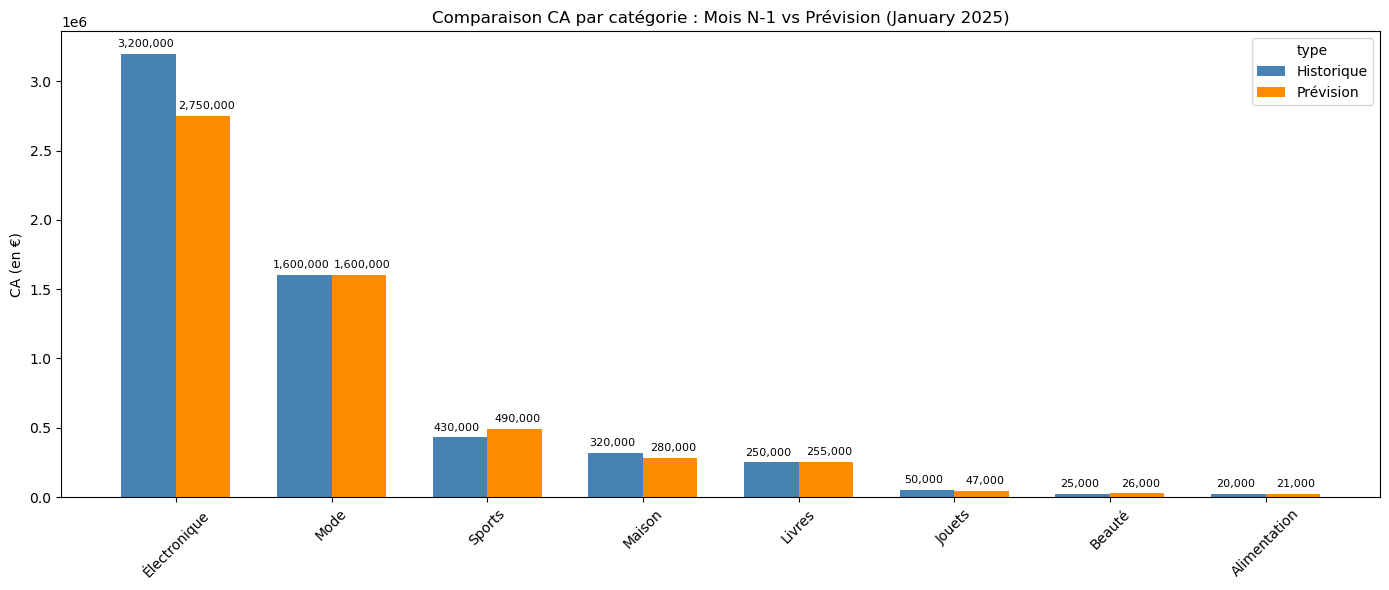

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Données d'exemple (à remplacer par vos vraies valeurs si besoin)
categories = ['Alimentation', 'Beauté', 'Jouets', 'Livres', 'Maison', 'Mode', 'Sports', 'Électronique']
ca_2024 = [20000, 25000, 50000, 250000, 320000, 1600000, 430000, 3200000]
ca_2025 = [21000, 26000, 47000, 255000, 280000, 1600000, 490000, 2750000]

# Création du DataFrame
df_comparaison = pd.DataFrame({
    'Catégorie': categories,
    'Historique': ca_2024,
    'Prévision': ca_2025
})

# Tri décroissant par CA moyen
df_comparaison['CA_moyen'] = (df_comparaison['Historique'] + df_comparaison['Prévision']) / 2
df_comparaison = df_comparaison.sort_values(by='CA_moyen', ascending=False).reset_index(drop=True)

# Paramètres pour le graphique
x = range(len(df_comparaison))
width = 0.35

# Création du graphique
plt.figure(figsize=(14, 6))
bars1 = plt.bar([p - width/2 for p in x], df_comparaison['Historique'], width=width, label='Historique', color='steelblue')
bars2 = plt.bar([p + width/2 for p in x], df_comparaison['Prévision'], width=width, label='Prévision', color='darkorange')

# Mise en forme
plt.xticks(x, df_comparaison['Catégorie'], rotation=45)
plt.ylabel("CA (en €)")
plt.title("Comparaison CA par catégorie : Mois N-1 vs Prévision (January 2025)")
plt.legend(title='type')

# Affichage des valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.02, height + 50000, f'{int(height):,}', ha='center', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + 0.02, height + 50000, f'{int(height):,}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


#### Interprétation :
| Catégorie                                | Évolution visible                                | Interprétation                                                                                         |
| ---------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------------------ |
| **Électronique**                         | **Forte régression** (prévision bien en dessous) | Le modèle anticipe une baisse de la demande, peut-être exagérée si aucune saisonnalité ne le justifie. |
| **Sports**                               | **Progression nette**                            | Le modèle semble capter une dynamique de croissance récente.                                           |
| **Maison**                               | **Baisse modérée**                               | Potentielle erreur de tendance si la saisonnalité n’a pas été modélisée.                               |
| **Mode**                                 | **Stabilité parfaite**                           | Le modèle reproduit exactement le CA précédent : attention à un effet d’inertie.                       |
| **Jouets**, **Beauté**, **Alimentation** | **Petits écarts**                                | Variabilité faible, prédictions plausibles si peu de saisonnalité.                                     |
#### 2. Risques ou limites visibles
Pas d'effet de saison détectable : Le modèle semble linéaire ou faiblement sensible aux événements particuliers (soldes, fêtes, etc.).
Biais d’inertie : Certaines prévisions sont identiques à l’année précédente (ex. : "Mode") → cela peut indiquer une dépendance excessive à la variable ca_mois_prec.
Absence de pics : Aucun pic de croissance exceptionnel n'est anticipé. Le modèle semble conservateur.
#### 3. Hypothèse sur le comportement du modèle
À partir du graphique, on peut supposer que :
Le modèle est fortement guidé par les moyennes mobiles et les 2 derniers mois de ventes (ca_mois_prec, ca_mois_prec_2, moyenne_mobile_3m).
Il est faiblement influencé par des variables exogènes (promotions, campagnes, jours fériés) → car non présentes dans vos features.
#### ✅ Conclusion
Même sans les vraies données de 2025 :
Vous pouvez affirmer que le modèle ne génère pas de prédictions aberrantes (ex. : CA négatif ou > x2),
Mais qu’il manque probablement de réactivité aux événements (ex : effets saisonniers ou commerciaux),
Et qu’un enrichissement des features (avec date, promotions, jours fériés, etc.) serait nécessaire pour améliorer la précision et le réalisme.